# Ex2. Implement Spiking CNN for Image Recognition (CSNN) on MNIST (handwritten digits).

1. Convert a pre-trained Convolutional Neural Network (CNN) into a Spiking CNN (CSNN).
2. Use rate-based encoding to convert images into spike trains.
3. Simulate SNN inference with LIF neurons and evaluation classification performance.

In [1]:
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt
import snntorch.spikegen as spikegen

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

/var/folders/sk/75h5138j22nfbhs2nc6fv2qm0000gn/T/ipykernel_86222/2115671503.py:3: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [2]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [3]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 50

In [5]:
#1. Convert a pre-trained Convolutional Neural Network (CNN) into a Spiking CNN (CSNN).
net = nn.Sequential(
    nn.Conv2d(1,12,5),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Conv2d(12, 64, 5),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Flatten(),
    nn.Linear(64*4*4, 10),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
    ).to(device)

In [6]:
def encode_data(data, num_steps):
  return spikegen.rate(data, num_steps=num_steps, gain=0.25);

def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)

  # 2. Use rate-based encoding to convert images into spike trains.
  spike_data = encode_data(data, num_steps=num_steps)
  for step in range(num_steps):
      spk_out, mem_out = net(spike_data[step]) 
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total



In [7]:
loss_fn = SF.ce_rate_loss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 1
loss_hist = []
test_acc_hist = []
counter = 0

for epoch in range(num_epochs):

    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        #forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)
        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # 3. Simulate SNN inference with LIF neurons and evaluation classification performance.
        if counter % 50 == 0:
            with torch.no_grad():
                net.eval()

                # Test set forward pass
                test_acc = batch_accuracy(test_loader, net, num_steps)
                print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())

        counter += 1

Iteration 0, Test Acc: 9.81%

Iteration 50, Test Acc: 78.26%

Iteration 100, Test Acc: 89.22%

Iteration 150, Test Acc: 91.77%

Iteration 200, Test Acc: 93.37%

Iteration 250, Test Acc: 94.13%

Iteration 300, Test Acc: 94.97%

Iteration 350, Test Acc: 95.61%

Iteration 400, Test Acc: 94.38%

Iteration 450, Test Acc: 95.03%



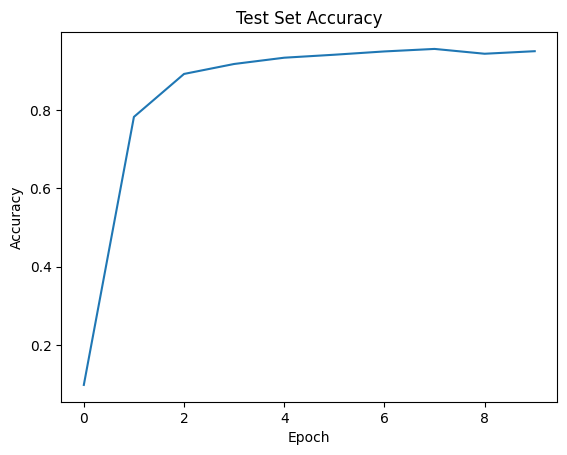

In [8]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()